In [32]:
# Updated version - determines the correct target for each time based on the prediction length and the future labels
# The blockage points are returned so that predictions which are made during blockage points can be ignored during training

import torch
import numpy as np
import os
import re
import matplotlib.pyplot as plt

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

def preprocess_data_2(scenario_num, pred_length):
	# Number of samples in the train and test datasets for each of the scenarios
	scen_20_train_len = 44255 #64254
	scen_20_test_len = 64254 - 44255 - 1 #70837 - 64254
	scen_17_train_len = 65000
	scen_17_test_len = 5000

	scenario_map = {17:[scen_17_train_len, scen_17_test_len], 20:[scen_20_train_len, scen_20_test_len]}

	# Get the appropriate directory to pull data from
	data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
	files = os.listdir(data_dir)

	# Load the mmwave samples
	full_data = []
	for file in sorted(files, key=get_file_num):
		data = np.loadtxt(data_dir + '\\' + file)
		full_data.append(data)
	full_data = np.row_stack(full_data)
	# print(full_data.shape)

	observation_size = full_data.shape[1]
	full_len = full_data.shape[0]

	# Normalize the data
	data_mean = np.sum(full_data)/(observation_size * full_len)
	data_stdev = np.linalg.norm(full_data)/np.sqrt(observation_size * full_len)
	full_data = (full_data - data_mean)/data_stdev

	# Calculate the number of samples available for the train and test sets, adjusting based on the prediction length
	total_train_observations = scenario_map[scenario_num][0]
	total_test_observations = scenario_map[scenario_num][1] - pred_length

	# Split into train and test data
	train_data = np.zeros((1, total_train_observations, observation_size), dtype=np.float32)
	test_data = np.zeros((1, total_test_observations, observation_size), dtype=np.float32)
	train_data[0,:,:] = full_data[:total_train_observations,:]
	test_data[0,:,:] = full_data[total_train_observations:-(pred_length+1),:]

	train_len = total_train_observations
	test_len = total_test_observations - pred_length

	# Get the target predictions
	labels_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\label_data".format(scenario_num)
	files = os.listdir(labels_dir)

	labels = []
	for file in sorted(files, key=get_file_num):
		label = np.loadtxt(labels_dir + '\\' + file)
		labels.append(label)
	labels = np.expand_dims(np.array(labels), 1)

	# Get the actual prediction targets
	targets = []
	for i in range(labels.shape[0]):
		if np.sum(labels[i:i+pred_length+1]) > 0:
			targets.append(1)
		else:
			targets.append(0)
	targets = np.expand_dims(np.array(targets), 1)

	blockage_points = np.where(labels == 1)[0]
	# Discards the data points where a blockage is in effect
	# If we are going to use this, we need to so it before splitting into train and test sets
	# targets = np.delete(targets,blockage_points,0)

	# plt.plot(labels[75:200])
	# plt.plot(0.99*targets[75:200])
	# plt.show()

	train_targets = targets[pred_length:train_len+pred_length]
	test_targets = targets[train_len+pred_length:]

	train_data = torch.from_numpy(train_data)
	train_targets = torch.from_numpy(train_targets)
	test_data = torch.from_numpy(test_data)
	test_targets = torch.from_numpy(test_targets)

	train_blockage_points = blockage_points[blockage_points < train_len]
	test_blockage_points = blockage_points[blockage_points >= train_len]

	return [train_data, train_targets, test_data, test_targets, train_blockage_points, test_blockage_points]


In [33]:
preprocess_data_2(17, 1)

[tensor([[[-0.2794, -0.2243, -0.2198,  ..., -0.2221, -0.2115, -0.3635],
          [-0.2247, -0.2395, -0.1994,  ..., -0.2221, -0.2115, -0.3635],
          [-0.2810, -0.2321, -0.2140,  ..., -0.2569, -0.1926, -0.3545],
          ...,
          [-0.4680, -0.3959, -0.4107,  ..., -0.4347, -0.3806, -0.4217],
          [-0.4547, -0.3949, -0.4195,  ..., -0.4151, -0.3727, -0.4227],
          [-0.4654, -0.3998, -0.4238,  ..., -0.4286, -0.3977, -0.4174]]]),
 tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]], dtype=torch.int32),
 tensor([[[-0.4626, -0.3931, -0.4140,  ..., -0.4290, -0.3974, -0.4242],
          [-0.4477, -0.3904, -0.4176,  ..., -0.4321, -0.3931, -0.4216],
          [-0.4549, -0.3911, -0.4155,  ..., -0.4030, -0.3900, -0.4237],
          ...,
          [-0.5045, -0.4985, -0.4991,  ..., -0.4984, -0.5030, -0.5068],
          [-0.5019, -0.4997, -0.4992,  ..., -0.4992, -0.4974, -0.5065],
          [-0.5036, -0.4982, -0.4985,  ..., -0.4983, -0.

In [2]:
# More closely resembles the data preparation used in the Deepsense paper
import torch
import numpy as np
import os
import re
import matplotlib.pyplot as plt

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

scenario_num = 17
pred_length = 1

# Number of samples in the train and test datasets for each of the scenarios
scen_20_train_len = 44255 #64254
scen_20_test_len = 64254 - 44255 - 1 #70837 - 64254
scen_17_train_len = 65000
scen_17_test_len = 5000

scenario_map = {17:[scen_17_train_len, scen_17_test_len], 20:[scen_20_train_len, scen_20_test_len]}

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# # Load the mmwave samples
# full_data = []
# for file in sorted(files, key=get_file_num):
# 	data = np.loadtxt(data_dir + '\\' + file)
# 	full_data.append(data)
# full_data = np.row_stack(full_data)
# # print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# Normalize the data
data_mean = np.sum(full_data)/(observation_size * full_len)
data_stdev = np.linalg.norm(full_data)/np.sqrt(observation_size * full_len)
full_data = (full_data - data_mean)/data_stdev

# Calculate the number of samples available for the train and test sets, adjusting based on the prediction length
total_train_observations = scenario_map[scenario_num][0]
total_test_observations = scenario_map[scenario_num][1] - pred_length

# Split into train and test data
train_data = np.zeros((1, total_train_observations, observation_size), dtype=np.float32)
test_data = np.zeros((1, total_test_observations, observation_size), dtype=np.float32)
train_data[0,:,:] = full_data[:total_train_observations,:]
test_data[0,:,:] = full_data[total_train_observations:-(pred_length+1),:]

train_len = total_train_observations
test_len = total_test_observations - pred_length

# Get the target predictions
labels_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\label_data".format(scenario_num)
files = os.listdir(labels_dir)

# labels = []
# for file in sorted(files, key=get_file_num):
# 	label = np.loadtxt(labels_dir + '\\' + file)
# 	labels.append(label)
# labels = np.expand_dims(np.array(labels), 1)

# Get the actual prediction targets
targets = []
for i in range(labels.shape[0]):
	if np.sum(labels[i:i+pred_length+1]) > 0:
		targets.append(1)
	else:
		targets.append(0)
targets = np.expand_dims(np.array(targets), 1)

blockage_points = np.where(labels == 1)[0]

train_targets = targets[pred_length:train_len+pred_length]
test_targets = targets[train_len+pred_length:]

train_data = torch.from_numpy(train_data)
train_targets = torch.from_numpy(train_targets)
test_data = torch.from_numpy(test_data)
test_targets = torch.from_numpy(test_targets)

train_blockage_points = blockage_points[blockage_points < train_len]
test_blockage_points = blockage_points[blockage_points >= train_len]


In [74]:
# For each blockage point which does not have a blockage point within the preceding Tobs samples, generate a set of Tp = pred_length examples featuring blockage
# by applying a sliding window that increases the number of samples between the last observation and the blockage by 1 each time. Only do this as long as it does
# not introduce a blockage into the observation window.
# We then need to find an equal number of non-blockage examples by generating a list of candidates and picking the examples such that they are well spread out
def split_data(samples, labels, blockage_points, Tobs, Tp):
	blockage_array = np.array(blockage_points, dtype=np.int32)
	# Determine the spacing between blockage points
	blockage_spacings = blockage_array[1:] - blockage_array[:-1]
	# Determine the blockage points which mark the start of a blockage
	blockage_start_points = np.array([blockage_points[0]], dtype=np.int32)
	blockage_start_points = np.concatenate([blockage_start_points, (blockage_points[1:])[blockage_spacings > 1]])
	# Generate a list of <observation sequence, label> pairings with blockages
	blk_obs_target_pairs = []
	for bsp in blockage_start_points.tolist():
		# Make sure there is at least a full Tobs observations available, or else we cannot use the blockage
		if Tobs > bsp:
			continue
		for j in range(Tp):
			# Make sure there are enough observation samples available 
			if Tobs + j > bsp:
				continue
			# Make sure the observation samples do not contain blockages
			if np.sum(labels[bsp - (Tobs + j):bsp]) > 0:
				continue
			obs = samples[bsp - (Tobs + j):bsp]
			blk_obs_target_pairs.append([obs, 1])
	# print(len(obs_target_pairs)) # Number of pairs extracted
	# print(blockage_start_points.shape) # Number of blockages
	# print(blockage_spacings[np.logical_and(blockage_spacings < 16, blockage_spacings > 1)].shape) # Number of blockages that are within an interval of another blockage

	# Generate a list of <observation sequence, label> pairings without blockages
	no_blk_candidate_pairs = []
	# On each iteration, the index i points to the last observation sample of the potential set of samples
	for i in range(Tobs,samples.shape[0] - Tp):
		if np.sum(labels[i-Tobs:i+Tp+1]) == 0:
			obs = samples[i-Tobs:i+1]
			no_blk_candidate_pairs.append([obs, 0])
	# print(len(no_blk_obs_target_pairs))

	# Uniformly sample the pairings without blockages to get a subset matching the number of pairings with blockages
	# print(np.random.choice(no_blk_candidate_pairs,len(blk_obs_target_pairs),replace=False))
	choices = np.random.choice(len(no_blk_candidate_pairs), len(blk_obs_target_pairs), replace=False)
	no_blk_obs_target_pairs = [no_blk_candidate_pairs[i] for i in choices]
	# no_blk_obs_target_pairs = np.random.choice(no_blk_candidate_pairs,len(blk_obs_target_pairs),replace=False)

	return [blk_obs_target_pairs, no_blk_obs_target_pairs]
	

In [77]:
# The Deepsense paper used Tobs = 16 for the outdoor datasets
blk_obs_target_pairs, no_blk_obs_target_pairs = split_data(full_data, labels, blockage_points, 16, 1)
print(len(blk_obs_target_pairs), len(no_blk_obs_target_pairs))

323 323


In [81]:
import torch
import numpy as np
import os
import re
import matplotlib.pyplot as plt

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

scenario_num = 17
obs_length = 16
pred_length = 1
train_ratio = 90/100

# Number of samples in the train and test datasets for each of the scenarios
scen_20_train_len = 44255 #64254
scen_20_test_len = 64254 - 44255 - 1 #70837 - 64254
scen_17_train_len = 65000
scen_17_test_len = 5000

scenario_map = {17:[scen_17_train_len, scen_17_test_len], 20:[scen_20_train_len, scen_20_test_len]}

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# # Load the mmwave samples
# full_data = []
# for file in sorted(files, key=get_file_num):
# 	data = np.loadtxt(data_dir + '\\' + file)
# 	full_data.append(data)
# full_data = np.row_stack(full_data)
# # print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# Normalize the data
data_mean = np.sum(full_data)/(observation_size * full_len)
data_stdev = np.linalg.norm(full_data)/np.sqrt(observation_size * full_len)
full_data = (full_data - data_mean)/data_stdev

# Get the split data
blk, no_blk = split_data(full_data, labels, blockage_points, obs_length, pred_length)

# Divide into train and test data
print(len(blk))
test_start_blk = (int)(np.floor(len(blk)*train_ratio))
blk_train = blk[:test_start_blk]
blk_test = blk[test_start_blk:]
print(len(blk_train), len(blk_test))
print(len(no_blk))
test_start_no_blk = (int)(np.floor(len(no_blk)*train_ratio))
no_blk_train = no_blk[:test_start_no_blk]
no_blk_test = no_blk[test_start_no_blk:]
print(len(no_blk_train), len(no_blk_test))


323
290 33
323
290 33


In [4]:
import torch
import numpy as np
import os
import re

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(17)
files = os.listdir(data_dir)

nums = list(range(0,70001))
found_nums = []

# Load the mmwave samples
full_data = []
for file in sorted(files, key=get_file_num):
	found_nums.append(int(re.findall(r'\d+', file)[0]))
	data = np.loadtxt(data_dir + '\\' + file)
	full_data.append(data)
full_data = np.row_stack(full_data)
print(full_data.shape) 

for num in nums:
	if num not in found_nums:
		print(num)

(70001, 64)
0


(70001, 64)


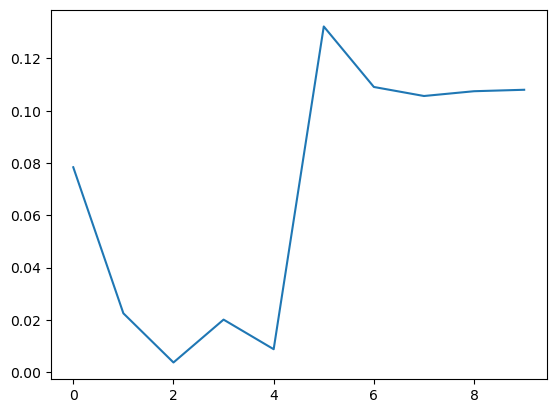

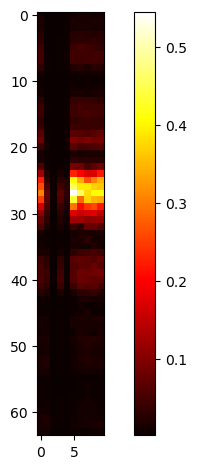

In [19]:
# Visualize the received signal power
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import os
import re

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

scenario_num = 17
pred_length = 0

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# Load the mmwave samples
full_data = []
for file in sorted(files, key=get_file_num):
	data = np.loadtxt(data_dir + '\\' + file)
	full_data.append(data)
full_data = np.row_stack(full_data)
print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# fig = plt.figure(figsize=(18,2))
# ax = fig.axes
# # ax.imshow(random.rand(8, 90), interpolation='nearest')

# For scenario 11, 0.5 is a good threshold
# Get the max of each column; columns  where the max is < 0.3 are considered blockage times
# blockages = np.max(full_data, axis=0) < 0.3
# print(np.nonzero(blockages))

# Alternate way of finding blockage points which gives the same results
# blockages = [np.sqrt(np.mean(full_data[:,i]**2)) for i in range(300)]
blockages = [np.sqrt(np.mean(full_data[i,:]**2)) for i in range(89,99)]
# print(blockages)
plt.plot(blockages)
plt.show()

plt.imshow(full_data[89:99,:].T, cmap=cmap.hot, interpolation='nearest')
plt.tight_layout()
plt.colorbar()
plt.show()